In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [18]:
encoder_name = "esm1_t6_43M_UR50S"
    
# "esm1_t6_43M_UR50S"
# "esm1_t12_85M_UR50S"
# "esm1_t34_670M_UR50S"
# "esm1b_t33_650M_UR50S"

In [19]:
import torch

# Load ESM-1b model
original_model, alphabet = torch.hub.load(
            "facebookresearch/esm:main", model=encoder_name
        )
batch_converter = alphabet.get_batch_converter()
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

original_model.eval()
with torch.no_grad():
    original_results = original_model(batch_tokens, repr_layers=[6], return_contacts=False)
original_reps = original_results["representations"][6].numpy().mean(axis=1).flatten()

Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


In [11]:
w = torch.empty(3, 5)
w

tensor([[1.7937e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7937e-42, 0.0000e+00],
        [1.4013e-45, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [12]:
torch.nn.init.zeros_(w)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [13]:
w

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
for k, p in original_model.state_dict().items():
    print(f"{k}: dim {p.dim()}")

In [20]:
import torch
from torch.nn import Parameter  
from torch.nn.init import xavier_uniform_, xavier_normal_, kaiming_uniform_, uniform_, normal_, constant_, _calculate_fan_in_and_fan_out

In [21]:
import math


def cal_bound(model: torch.nn.Module, layer_name: str):
    """Return bound for reinit given model and layer name"""
    assert "bias" in layer_name, f"no bias in {layer_name}"
    fan_in, _ = _calculate_fan_in_and_fan_out(model.state_dict()[layer_name.replace("bias", "weight")])
    return 1 / math.sqrt(fan_in) if fan_in > 0 else 0


In [26]:
import copy

def reset_parameters(model, encoder_name):
    """Initiate parameters in the transformer model."""

    for layer_name, p in model.state_dict().items():
        # what esm1b and esm1 have in common
        if "_proj" in layer_name:
            if "weight" in layer_name:
                if "out" in layer_name:
                    xavier_uniform_(p)
                else:
                    xavier_uniform_(p, gain=1 / math.sqrt(2))
            elif "bias" in layer_name:
                if "out" in layer_name:
                    constant_(p, 0.0)
                else:
                    bound = cal_bound(model=model, layer_name=layer_name)
                    uniform_(p, -bound, bound)

        # esm1b enced up using LayerNorm so the same    
        if "layer_norm" in layer_name:
            if "weight" in layer_name:
                Parameter(torch.ones_like(p))
            elif "bias" in layer_name:
                Parameter(torch.zeros_like(p))
        
        if ("layers" and "fc" in layer_name) or ("contact_head" in layer_name):
            if "weight" in layer_name:
                kaiming_uniform_(p, a=math.sqrt(5))
            elif "bias" in layer_name:
                bound = cal_bound(model=model, layer_name=layer_name)
                uniform_(p, -bound, bound)
        
        if "esm1b_" in encoder_name:
            
            if "embed_positions" in layer_name:
                normal_(p)

            if layer_name == "lm_head.weight":
                xavier_uniform_(p)
            
            if layer_name == "lm_head.bias" or "lm_head.layer_norm.bias":
                Parameter(torch.zeros_like(p))

            if "dense" in layer_name:
                if "weight" in layer_name:
                    kaiming_uniform_(p, a=math.sqrt(5))
                elif "bias" in layer_name:
                    bound = cal_bound(model=model, layer_name=layer_name)
                    uniform_(p, -bound, bound)
        
        elif "esm1_" and "bias_" in encoder_name:
            xavier_normal_(p)
    
    return model

def resample_parameters(model):

    for p in model.parameters():
        if p.dim() > 1:
            print(p)
            xavier_normal_(p)
    
    return model

In [23]:
import matplotlib.pyplot as plt

In [26]:
from torch.nn import Parameter

In [27]:
Parameter(torch.Tensor(1, 1, 10))

Parameter containing:
tensor([[[-2.9612e-08,  4.5560e-41,  2.6462e+01,  3.0697e-41,  1.4013e-45,
           0.0000e+00,  0.0000e+00,  2.3694e-38,  6.7262e-44,  0.0000e+00]]],
       requires_grad=True)

In [29]:
zeros_(Parameter(torch.Tensor(1, 1, 10)))

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)

In [24]:
from scr.params.sys import DEVICE

In [27]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model, encoder_name)
# model = resample_parameters(model, encoder_name)
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
reset_reps = results["representations"][6].numpy().mean(axis=1).flatten()

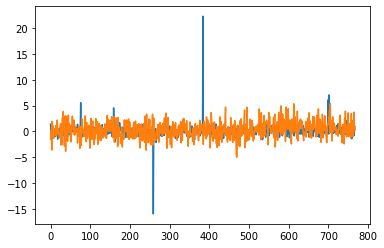

In [28]:
plt.plot(original_reps)
plt.plot(reset_reps)
# plt.plot(resample_reps)

In [13]:
from sequence_models.pretrained import load_model_and_alphabet

original_model, collater = load_model_and_alphabet('carp_600k')

seqs = [['MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG']]
x = collater(seqs)[0]  # (n, max_len)
original_rep = original_model(x).detach().numpy().mean(axis=1)  # (n, max_len, d_model)
original_rep.shape

(1, 128)

In [14]:
import copy

In [15]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model)
model.eval()  # disables dropout for deterministic results

reset_reps = model(x).detach().numpy().mean(axis=1)
reset_reps.shape

(1, 128)

In [16]:
model = copy.deepcopy(original_model).to(DEVICE)
model = resample_parameters(model)
model.eval()  # disables dropout for deterministic results

resample_reps = model(x).detach().numpy().mean(axis=1)
resample_reps.shape

(1, 128)

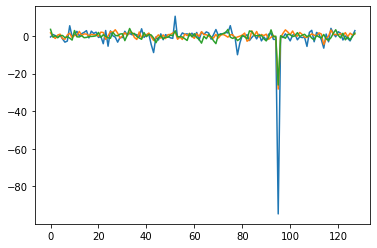

In [17]:
plt.plot(original_rep.T)
plt.plot(reset_reps.T)
plt.plot(resample_reps.T)